In [18]:
import numpy as np
import cv2
import os
from scipy.ndimage import convolve

In [19]:
pg = f"Pepper_Gaussian.tif"
pi = f"Pepper_Impulse.tif"
p = f"../Test_Images/Pepper.tif"

In [20]:
if os.path.exists(p):
    print("t")

t


In [21]:
class ColorImageProcessor:
    @staticmethod
    def rgb2yuv(rgb_image):
        """Convert RGB image to YUV color space"""
        yuv_image = np.zeros_like(rgb_image, dtype=np.float32)

        # Y channel (Luma)
        yuv_image[:,:,0] = (0.299 * rgb_image[:,:,0] + 
                             0.587 * rgb_image[:,:,1] + 
                             0.114 * rgb_image[:,:,2])

        # U channel
        yuv_image[:,:,1] = (-0.169 * rgb_image[:,:,0] - 
                             0.331 * rgb_image[:,:,1] + 
                             0.500 * rgb_image[:,:,2])

        # V channel
        yuv_image[:,:,2] = (0.500 * rgb_image[:,:,0] - 
                             0.419 * rgb_image[:,:,1] - 
                             0.081 * rgb_image[:,:,2])

        return yuv_image
    @staticmethod
    def yuv2rgb(yuv_image):
        """Convert YUV image back to RGB color space"""
        rgb_image = np.zeros_like(yuv_image, dtype=np.float32)

        # Red channel
        rgb_image[:,:,0] = (yuv_image[:,:,0] + 
                             1.402 * yuv_image[:,:,2])

        # Green channel
        rgb_image[:,:,1] = (yuv_image[:,:,0] - 
                             0.344 * yuv_image[:,:,1] - 
                             0.714 * yuv_image[:,:,2])

        # Blue channel
        rgb_image[:,:,2] = (yuv_image[:,:,0] + 
                             1.772 * yuv_image[:,:,1])

        return np.clip(rgb_image, 0, 1)

    @staticmethod
    def smart_linear_filter(image):
        """Applies a smart linear filter using a predetermined kernel."""
        kernel = np.array([[1, 2, 1],
                           [2, 4, 2],
                           [1, 2, 1]]) / 16  # Normalized Gaussian kernel
        image = np.clip(image, 0, 255).astype(np.float32)
        filtered_image = convolve(image, kernel, mode='reflect')
        return filtered_image

    @staticmethod
    def rank_order_ev_filter(image):
        """Applies rank-order extreme value filtering."""
        stand = np.std(image)
        window_size = 3
        pad_size = window_size // 2
        padded_image = np.pad(image, pad_size, mode='reflect')
        filtered_image = np.zeros_like(image)
        for i in range(image.shape[0]): 
            for j in range(image.shape[1]):
                window = padded_image[i:i + window_size, j:j + window_size]
                flatten = window.flatten()
                central_pixel = image[i, j]
                ev_interval = [px for px in flatten if abs(px - central_pixel) <= stand]
                filtered_image[i, j] = np.mean(ev_interval) if ev_interval else central_pixel
        return filtered_image

    @staticmethod
    def median_filter(image):
        """Applies median filtering."""
        kernel_size = 3
        pad_size = kernel_size // 2
        padded_image = np.pad(image, pad_size, mode='reflect')
        filtered_image = np.zeros_like(image)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded_image[i:i + kernel_size, j:j + kernel_size]
                filtered_image[i, j] = np.median(region)
        return filtered_image
    @staticmethod
    def compute_metrics(original, filtered):
        """Compute Peak Signal-to-Noise Ratio (PSNR) and Root Mean Square Error (RMSE)"""
        mse = np.mean((original - filtered) ** 2)
        rmse = np.sqrt(mse)
        psnr = 10 * np.log10(1 / mse) if mse > 0 else float('inf')
        return psnr, rmse


In [22]:
def process_noise_images():
    p = "original_image.png"
    pg = "gaussian_noisy_image.png"
    pi = "impulse_noisy_image.png"

    # Load images
    gaussian_noisy = cv2.imread(pg, cv2.IMREAD_COLOR) / 255.0
    impulse_noisy = cv2.imread(pi, cv2.IMREAD_COLOR) / 255.0
    original = cv2.imread(p, cv2.IMREAD_COLOR) / 255.0

    print("Gaussian Noise Processing Results:")
    gaussian_rgb_smart = np.zeros_like(gaussian_noisy)
    gaussian_rgb_ev = np.zeros_like(gaussian_noisy)

    for channel in range(3):
        gaussian_rgb_smart[:,:,channel] = ColorImageProcessor.smart_linear_filter(gaussian_noisy[:,:,channel])
        gaussian_rgb_ev[:,:,channel] = ColorImageProcessor.rank_order_ev_filter(gaussian_noisy[:,:,channel])

        psnr, rmse = ColorImageProcessor.compute_metrics(original[:,:,channel], gaussian_rgb_smart[:,:,channel])
        print(f"RGB Channel {channel+1} - Smart Filter: PSNR = {psnr:.2f}, RMSE = {rmse:.4f}")

        psnr, rmse = ColorImageProcessor.compute_metrics(original[:,:,channel], gaussian_rgb_ev[:,:,channel])
        print(f"RGB Channel {channel+1} - EV Filter: PSNR = {psnr:.2f}, RMSE = {rmse:.4f}")

    gaussian_yuv = ColorImageProcessor.rgb2yuv(gaussian_noisy)
    y_smart = ColorImageProcessor.smart_linear_filter(gaussian_yuv[:,:,0])
    y_ev = ColorImageProcessor.rank_order_ev_filter(gaussian_yuv[:,:,0])

    gaussian_smart_yuv = gaussian_yuv.copy()
    gaussian_smart_yuv[:,:,0] = y_smart
    gaussian_smart_rgb = ColorImageProcessor.yuv2rgb(gaussian_smart_yuv)

    gaussian_ev_yuv = gaussian_yuv.copy()
    gaussian_ev_yuv[:,:,0] = y_ev
    gaussian_ev_rgb = ColorImageProcessor.yuv2rgb(gaussian_ev_yuv)
    print("\nImpulse Noise Processing Results:")
    impulse_rgb_median = np.zeros_like(impulse_noisy)

    for channel in range(3):
        impulse_rgb_median[:,:,channel] = ColorImageProcessor.median_filter(impulse_noisy[:,:,channel])
        psnr, rmse = ColorImageProcessor.compute_metrics(original[:,:,channel], impulse_rgb_median[:,:,channel])
        print(f"RGB Channel {channel+1} - Median Filter: PSNR = {psnr:.2f}, RMSE = {rmse:.4f}")

    impulse_yuv = ColorImageProcessor.rgb2yuv(impulse_noisy)
    y_median = ColorImageProcessor.median_filter(impulse_yuv[:,:,0])

    impulse_median_yuv = impulse_yuv.copy()
    impulse_median_yuv[:,:,0] = y_median
    impulse_median_rgb = ColorImageProcessor.yuv2rgb(impulse_median_yuv)

    cv2.imwrite('gaussian_rgb_smart.png', gaussian_rgb_smart * 255)
    cv2.imwrite('gaussian_rgb_ev.png', gaussian_rgb_ev * 255)
    cv2.imwrite('gaussian_y_smart.png', gaussian_smart_rgb * 255)
    cv2.imwrite('gaussian_y_ev.png', gaussian_ev_rgb * 255)
    cv2.imwrite('impulse_rgb_median.png', impulse_rgb_median * 255)
    cv2.imwrite('impulse_y_median.png', impulse_median_rgb * 255)

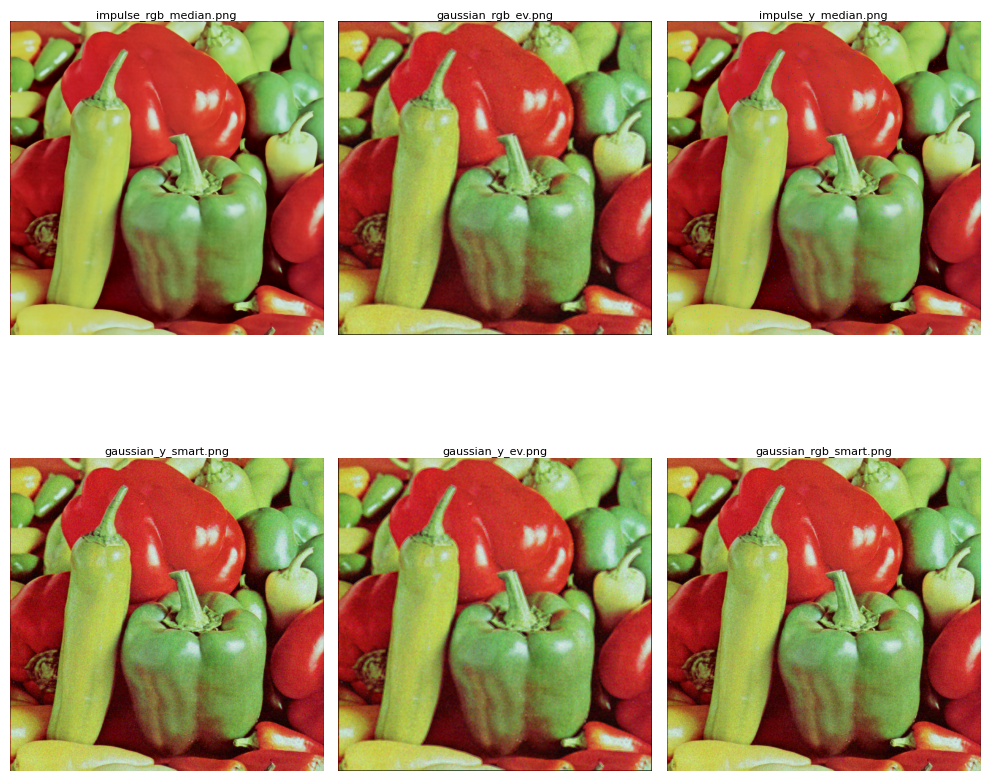

In [23]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def create_image_grid(folder_path, nrows, ncols):

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    image_files = image_files[:nrows * ncols]  

    for i, ax in enumerate(axes.flat):
        if i < len(image_files):
            img_path = os.path.join(folder_path, image_files[i])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(image_files[i], fontsize=8, pad=3)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


folder_path = "results"
create_image_grid(folder_path, 2, 3)